# BERT

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import os
import sys
import random
import shutil
os.chdir('../')
sys.path.append(os.getcwd())

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from transformers import BertTokenizerFast, BertForSequenceClassification
from transformers import EarlyStoppingCallback, TrainingArguments, Trainer
from transformers.tokenization_utils_base import BatchEncoding
from transformers.trainer_utils import EvalPrediction
from datasets import load_dataset
from datasets.arrow_dataset import Dataset
from IPython.display import clear_output
from typing import Callable, Dict

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42)

In [ ]:
MAX_LEN = 128
VALID_SPLIT = 0.3
BATCH_SIZE = 8
EPOCHS = 3
LEARNING_RATE = 1e-5
DR_RATE = 0.3
WARMUP_STEPS = 500
WEIGHT_DECAY = 0.01
METRIC = 'f1'

# device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device = torch.device('mps')

## Load Data

In [ ]:
df = pd.read_csv('./data/news.csv')
LABELS = ['neutral', 'positive', 'negative']
id2label = {idx:label for idx, label in enumerate(LABELS)}
label2id = {label:idx for idx, label in enumerate(LABELS)}
print(df.shape)
df.head()

(4840, 2)


,text,label
0,"According to Gran , the company has no plans t...",0
1,Technopolis plans to develop in stages an area...,0
2,The international electronic industry company ...,2
3,With the new production plant the company woul...,1
4,According to the company 's updated strategy f...,1


In [ ]:
df.label.value_counts()

0    2873
1    1363
2     604
Name: label, dtype: int64

## FinBERT Demo

In [ ]:
from transformers import pipeline

MODEL_NAME = 'yiyanghkust/finbert-tone'
finbert = BertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=len(LABELS))
tokenizer = BertTokenizerFast.from_pretrained(MODEL_NAME)
nlp = pipeline('sentiment-analysis', model=finbert, tokenizer=tokenizer)

In [ ]:
from sklearn.metrics import accuracy_score

Y = df.label.replace(id2label).tolist()
preds = [str(result['label']).lower() for result in nlp(df.text.tolist())]
print('Accuracy:', round(accuracy_score(Y, preds), 5))

Accuracy: 0.79236


## Data Preprocess

In [ ]:
dataset = load_dataset('csv', data_files='./data/news.csv', split='train')
dataset = dataset.train_test_split(test_size=VALID_SPLIT)
clear_output()
print(dataset['train'].shape, dataset['test'].shape)

(3388, 2) (1452, 2)


In [ ]:
def tokenize(model_path: str) -> Callable[[Dataset],BatchEncoding]:
    tokenizer = BertTokenizerFast.from_pretrained(model_path, problem_type='multi_label_classification')
    clear_output()
    return lambda examples: tokenizer(examples['text'], max_length=MAX_LEN, padding='max_length', truncation=True)

def one_hot(examples: Dataset) -> Dict[str,np.ndarray]:
    return {'labels':np.eye(len(LABELS))[examples['label']]}

def preprocess(data: Dataset, model_path: str, labeled=True) -> Dataset:
    encoded = data.map(tokenize(model_path), batched=True, remove_columns=['text'], load_from_cache_file=False)
    encoded = encoded.map(one_hot, remove_columns=['label'], load_from_cache_file=False) if labeled else encoded
    encoded.set_format('torch')
    return encoded

## Load Model

In [ ]:
def model(model_path: str, trainable=True) -> BertForSequenceClassification:
    model = BertForSequenceClassification.from_pretrained(
        model_path,
        problem_type='multi_label_classification',
        num_labels=len(LABELS),
        id2label=id2label,
        label2id=label2id,).to(device)
    clear_output()

    if not trainable:
        for param in model.bert.parameters():
            param.requires_grad = False

    return model

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

def compute_metrics(p: EvalPrediction) -> Dict:
    predictions, labels = p
    y_pred = np.argmax(predictions, axis=1)
    y_true = np.argmax(labels, axis=1)
    return {
        'precision': precision_score(y_true=y_true, y_pred=y_pred, average='micro'),
        'recall': recall_score(y_true=y_true, y_pred=y_pred, average='micro'),
        'f1': f1_score(y_true=y_true, y_pred=y_pred, average='micro'),
        'accuracy': accuracy_score(y_true=y_true, y_pred=y_pred),
    }

## Load Trainer

In [ ]:
def make_dirs(name: str) -> Dict[str,str]:
    required_dirs = {
        'root':'./saved','model_root':'./saved/models','model_dir':f'./saved/models/{name}',
        'logging_root':'./saved/logger','logging_dir':f'./saved/logger/{name}'}
    for dir in required_dirs.values():
        if not os.path.isdir(dir):
            os.mkdir(dir)
    return required_dirs

def training_args(model_name: str) -> TrainingArguments:
    required_dirs = make_dirs(model_name)
    return TrainingArguments(
        output_dir=required_dirs['model_dir'],
        evaluation_strategy='epoch',
        save_strategy='epoch',
        num_train_epochs=EPOCHS,
        per_device_train_batch_size=BATCH_SIZE,
        per_device_eval_batch_size=BATCH_SIZE,
        learning_rate=LEARNING_RATE,
        warmup_steps=WARMUP_STEPS,
        weight_decay=WEIGHT_DECAY,
        logging_dir=required_dirs['logging_dir'],
        load_best_model_at_end=True,
        metric_for_best_model=METRIC,
    )

def trainer(dataset: Dataset, model_name: str, model_path: str, labeled=True, trainable=True) -> Trainer:
    data_loader = preprocess(dataset, model_path, labeled)

    return Trainer(
        model=model(model_path, trainable),
        args=training_args(model_name),
        train_dataset=data_loader['train'],
        eval_dataset=data_loader['test'],
        compute_metrics=compute_metrics,
        callbacks = [EarlyStoppingCallback(3)],
    )

## Compare Models

In [ ]:
MODEL_PATH = {
    'bert_base': 'bert-base-uncased',
    'bert_large': 'bert-large-uncased',
    'finbert': 'ProsusAI/finbert',
    'finbert_tone': 'yiyanghkust/finbert-pretrain',
}

### BERT Base

In [ ]:
bert_base_trainer = trainer(dataset, 'bert_base', MODEL_PATH['bert_base'], trainable=False)

In [ ]:
bert_base_trainer.train()

### BERT Large

In [ ]:
bert_large_trainer = trainer(dataset, 'bert_large', MODEL_PATH['bert_large'], trainable=False)

In [ ]:
bert_large_trainer.train()

### FinBERT

In [ ]:
finbert_trainer = trainer(dataset, 'finbert', MODEL_PATH['finbert'], trainable=False)

In [ ]:
finbert_trainer.train()

### FinBERT Tune

In [ ]:
finbert_tone_trainer = trainer(dataset, 'finbert_tone', MODEL_PATH['finbert_tone'], trainable=False)

In [ ]:
finbert_tone_trainer.train()

## Visualization

In [ ]:
import json
from utils.fontlib import set_font_family

history = dict()

for model_name in MODEL_PATH.keys():
    output_dir = './saved/models/'+model_name
    recent_checkpoint = sorted(os.listdir(output_dir),key=lambda x: int(x.split('-')[1]))[-1]
    trainer_state = output_dir+'/'+recent_checkpoint+'/trainer_state.json'

    with open(trainer_state) as f:
        log_history = json.load(f)['log_history']

    history[model_name] = {'epoch'+str(int(log['epoch'])):round(log['eval_f1'],5) for log in log_history if log.get('eval_f1')}

history = pd.DataFrame(history)
history

,bert_base,bert_large,finbert,finbert_tone
epoch1,0.29545,0.61088,0.09366,0.61226
epoch2,0.60399,0.61019,0.62741,0.61226
epoch3,0.60468,0.61019,0.83127,0.61226


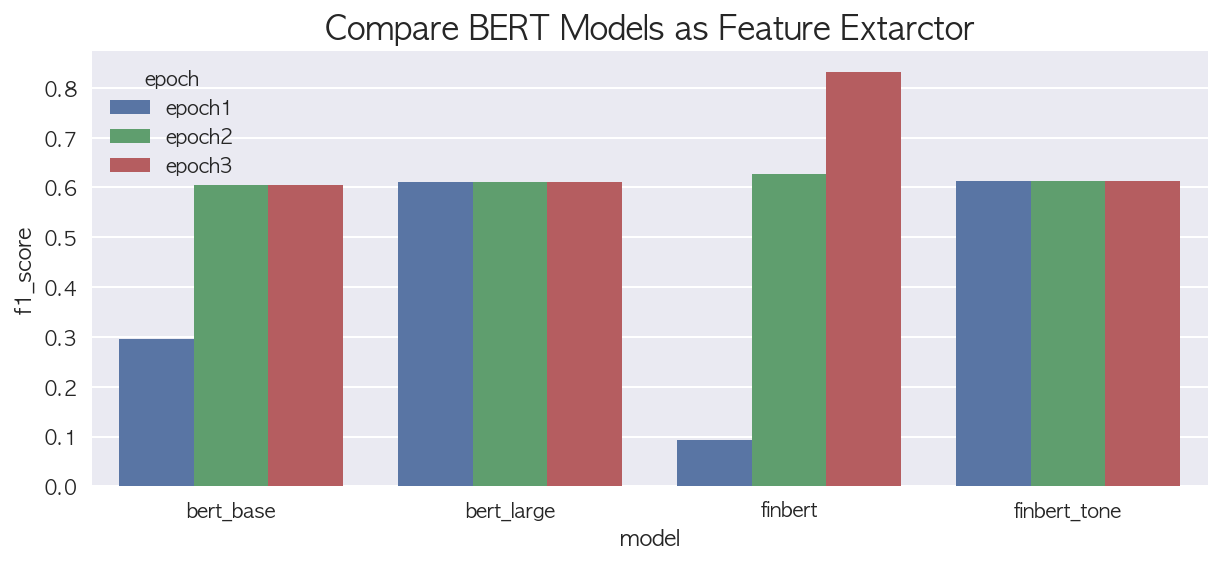

In [ ]:
f1 = history.values.reshape(-1).tolist()
epochs = np.array([[e]*len(history.columns) for e in history.index]).reshape(-1).tolist()
models = history.columns.tolist()*len(history)

compare_df = pd.DataFrame({'f1_score':f1,'epoch':epochs,'model':models})

set_font_family()
fig = plt.figure(figsize=(10,4))
sns.barplot(data=compare_df,x='model',y='f1_score',hue='epoch')
plt.title('Compare BERT Models as Feature Extarctor', fontsize=16)
plt.show()

In [ ]:
# !tensorboard --logdir=saved/logger/bert_base